# Finance Fundamental Concepts

## Sharpe Ratio

### <center>$\begin{split} S = \left( \frac{R_{p} - R_{f}}{\sigma_{p}} \right) \end{split}$</center>
#### <center>$\begin{split} \text{where } R_{p} &= \text{Expected Returns}\\
R_{f} &= \text{Risk Free Returns}\\
\sigma_{p} &= \text{Returns Standard Deviation}
\end{split}$</center>

**In general, the higher the Sharpe Ratio, the "better" the portfolio returns*

* Sharpe Ratio is based on a yearly basis, which does not work with a trading perspective
* $K$ factor is used to correct the Sharpe Ratio to different time windows
    * $K_{daily} = \sqrt{252}$
    * $K_{weekly} = \sqrt{52}$
    * $K_{monthly} = \sqrt{12}$
    * $S_{annualized} = K_{period} * S_{period}$

In [20]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
from scipy.optimize import minimize
from scipy import stats
import pandas_datareader as web

In [2]:
start_dt = datetime(2012, 1, 1)
end_dt = datetime(2017, 1, 1)

INIT_POSITION = 1000000

In [3]:
aapl = quandl.get('WIKI/AAPL.11', start_date=start_dt, end_date=end_dt)
cisco = quandl.get('WIKI/CSCO.11', start_date=start_dt, end_date=end_dt)
ibm = quandl.get('WIKI/IBM.11', start_date=start_dt, end_date=end_dt)
amzn = quandl.get('WIKI/AMZN.11', start_date=start_dt, end_date=end_dt)

In [19]:
for stock_df in (aapl, cisco, ibm, amzn):
    stock_df['Normed Return'] = stock_df['Adj. Close'] / stock_df.iloc[0]['Adj. Close']

# Portfolio Allocation: 30% aapl, 20% csco, 40% amzn, 10% ibm
for stock_df, allo in zip((aapl, cisco, ibm, amzn), (.3, .2, .1, .4)):
    stock_df['Allocation'] = stock_df['Normed Return'] * allo

for stock_df in (aapl, cisco, ibm, amzn):
    stock_df['Position'] = stock_df['Allocation'] * INIT_POSITION

In [42]:
aapl.head(3)

,Adj. Close,Normed Return,Allocation,Position
Date,,,,
2012-01-03,52.848787,1.000000,0.300000,300000.000000
2012-01-04,53.132802,1.005374,0.301612,301612.236461
2012-01-05,53.722681,1.016536,0.304961,304960.727573


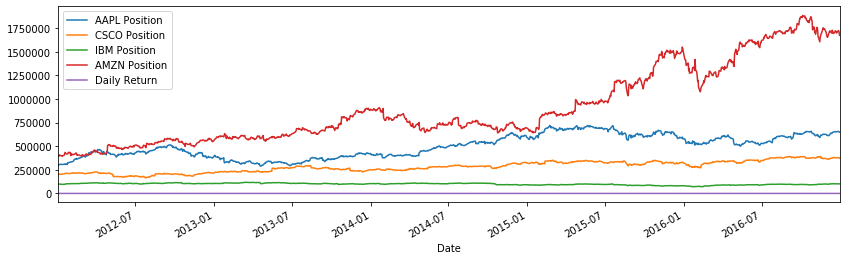

In [36]:
portfolio = pd.concat([aapl['Position'], cisco['Position'], ibm['Position'], amzn['Position']], axis=1)
portfolio.columns = ['AAPL Position', 'CSCO Position', 'IBM Position', 'AMZN Position']
portfolio['Total Position'] = portfolio.sum(axis=1)
portfolio['Daily Return'] = portfolio['Total Position'].pct_change(1)
portfolio.drop('Total Position', axis=1).plot(figsize=(14, 4));

Mean 0.0009023579071769599
Std 0.012896893878458078
Total Returns 179.97828220000912%


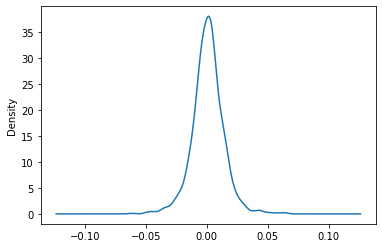

In [39]:
print('Mean', portfolio['Daily Return'].mean())
print('Std', portfolio['Daily Return'].std())
portfolio['Daily Return'].plot(kind='kde');
print('Total Returns {}%'.format(100 * (portfolio['Total Position'][-1] / portfolio['Total Position'][0] - 1)))

In [40]:
sr_daily = portfolio['Daily Return'].mean() / portfolio['Daily Return'].std()
sr_annual = (252 ** 0.5) * sr_daily
sr_annual

1.1106928405221748

## Portfolio Optimization
* Using Monte Carlo simulation
* Using optimization techniques
* Usage of Log returns => $\log r = \log\frac{p_{t}}{p_{t-1}}$

In [5]:
stocks = pd.concat([aapl['Adj. Close'], cisco['Adj. Close'], ibm['Adj. Close'], amzn['Adj. Close']], axis=1)
stocks.columns = ['AAPL', 'CSCO', 'IBM', 'AMZN']
stocks.pct_change(1).corr()

,AAPL,CSCO,IBM,AMZN
AAPL,1.000000,0.301990,0.297498,0.235487
CSCO,0.301990,1.000000,0.424672,0.284470
IBM,0.297498,0.424672,1.000000,0.258492
AMZN,0.235487,0.284470,0.258492,1.000000


AAPL    0.000614
CSCO    0.000497
IBM     0.000011
AMZN    0.001139
dtype: float64


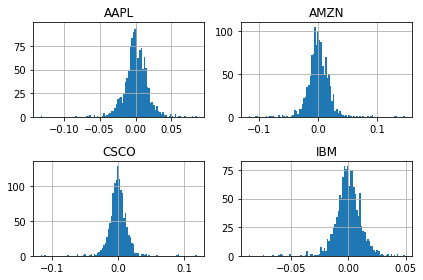

In [6]:
log_returns = np.log(stocks/stocks.shift(1))
log_returns.hist(bins=100);
plt.tight_layout()
print(log_returns.mean())

### Monte Carlo Simulations

In [8]:
%%time
# Monte Carlo simulations
np.random.seed(101)
n_portfolios = 5000
weights_arr = np.zeros((n_portfolios, len(stocks.columns)))
er_arr = np.zeros(n_portfolios)
ev_arr = np.zeros(n_portfolios)
sr_arr = np.zeros(n_portfolios)

for i in range(n_portfolios):
    weights = np.random.random(4)
    weights = weights / weights.sum()
    
    weights_arr[i, :] = weights

    expected_returns = (log_returns.mean() * weights * 252).sum()
    expected_volatility = np.sqrt(np.dot(weights, np.dot(log_returns.cov() * 252, weights)))

    sr = expected_returns / expected_volatility
    
    er_arr[i] = expected_returns
    ev_arr[i] = expected_volatility
    sr_arr[i] = sr

Wall time: 31.3 s


Optimal Portfolio:  [0.26188068 0.20759516 0.00110226 0.5294219 ]
Optimal SR:  1.0303260551271305


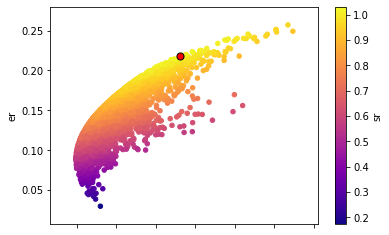

In [259]:
pd.DataFrame({'er': er_arr, 'ev': ev_arr, 'sr': sr_arr}).plot(kind='scatter', x='ev', y='er', c='sr', cmap='plasma');
plt.scatter(ev_arr[sr_arr.argmax()], er_arr[sr_arr.argmax()], c='r', s=50, edgecolors='black')
print('Optimal Portfolio: ', weights_arr[sr_arr.argmax()])
print('Optimal SR: ', sr_arr.max())

### Optimization Function in Scipy

In [7]:
# Optimizing weights, functions/objects to be used centred around weights concept
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    returns = np.sum(log_returns.mean() * weights) * 252
    volatilities = np.sqrt(np.dot(weights, np.dot(log_returns.cov() * 252, weights)))
    sr = returns / volatilities
    return np.array([returns, volatilities, sr])

def neg_sr(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

constraints = ({'type':'eq', 'fun': check_sum})  # weights constraints of check_sum(weights) == 0 (or sum(weights) = 1)
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))  # bounds for weights
init_guess = [0.25, 0.25, 0.25, 0.25]  # initial weights guess

opt_results = minimize(fun=neg_sr, x0=init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
print(opt_results)
print('Optimal Results: {}'.format(get_ret_vol_sr(opt_results.x)))

     fun: -1.0307168703349403
     jac: array([ 5.64306974e-05,  4.18424606e-05,  3.39921713e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.26628977, 0.20418982, 0.        , 0.5295204 ])
Optimal Results: [0.21885915 0.21233683 1.03071687]


### Plotting the Markowitz Efficient Portfolio Frontier (akin to PPC in Econs)

In [16]:
%%time
def get_vol(weights):
    return get_ret_vol_sr(weights)[1]

frontier_returns = np.linspace(0, 0.3, 100)
frontier_volatility = []

for frontier_return in frontier_returns:
    constraints = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - frontier_return}
    )
    opt_result = minimize(fun=get_vol, x0=init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    frontier_volatility.append(opt_result['fun'])

Wall time: 52.9 s


Optimal Portfolio:  [0.26188068 0.20759516 0.00110226 0.5294219 ]
Optimal SR:  1.0303260551271305


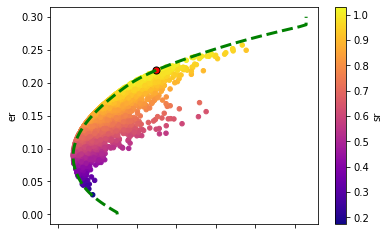

In [18]:
pd.DataFrame({'er': er_arr, 'ev': ev_arr, 'sr': sr_arr}).plot(kind='scatter', x='ev', y='er', c='sr', cmap='plasma');
plt.plot(frontier_volatility, frontier_returns, 'g--', linewidth=3)
plt.scatter(ev_arr[sr_arr.argmax()], er_arr[sr_arr.argmax()], c='r', s=50, edgecolors='black')
print('Optimal Portfolio: ', weights_arr[sr_arr.argmax()])
print('Optimal SR: ', sr_arr.max())

## Funds & Trades

### Fund Types
1. ETFs
    * Public / transparent for retail investors, made up of a basket of assets, for keeping a diversified long-term portfolio
    * Fees: 0.01 - 1%
2. Mutual Funds
    * Pool of funds collected from people, managed by fund managers
    * Fees: 0.5 - 3%
3. Hedge Funds
    * Aggressive / less regulated, mainly accessible to accredited investors
    * Fees: 2% of fund, 20% of profits
    
### Order Books
1. Process of trading market assets
    1. Order Request
        1. Buy/Sell
        2. Symbol
        3. Num Shares
        4. Order Type - LIMIT (i.e. Price limit) or MARKET (current price)
        5. Price (for LIMIT order)
    2. Ways of closing trades
        1. You --Buy/Sell--> Broker --> Exchange's Order Book
        2. You --Buy/Sell--> Broker<br>
           Other --Sell/Buy----^
        3. You --Buy/Sell--> Broker 1 --> **Dark Pool**<br>
           Other --Sell/Buy--> Broker 2 -----^
           
    Sent to exchange(s), and goes into an order book
    
        *You --Buy/Sell--> Broker --> NYSE/NASDAQ/BATS' Order Books*

2. Order Book

| Buy Orders || Sell Orders ||
| --- | --- | --- | --- |
| Shares | Bid | Shares | Ask |
|200|199.95|100|199.90|
|||50|199.91|
|||50|199.92|

### Biases/Inconsistencies in Data
1. E.g. Stock splits/dividends. These can "mess up" algo trading. Use Adj Close for corrected values.
2. E.g. Survivor Bias Free Data - If using benchmark e.g. SPY, make up of companies changes significantly especially after financial crisis. To backtest to even before financial crisis to account for such bias.

### Efficient Market Hypothesis (EMH)
* "Assumption" that beating the market is impossible as market reflects price efficiently

## Capital Assets Pricing Model (CAPM)

For a stock $i$:

$ r_{i}(t) = \beta_{i}r_{m}(t) + \alpha_{i}(t) $

$ \begin{split} \text{where } \beta_{i} &= \text{sensitivity to market returns, } r_{m} \\
\alpha_{i} &= \text{degree of beating the market}
\end{split}$

For a portfolio $p$ with $n$ stocks:

$ r_{p}(t) = \beta_{p}r_{m}(t) + \sum\limits_{i}^{n}w_{i}\alpha_{i}(t) $

In [21]:
spy_etf = web.DataReader('SPY', 'yahoo')

In [24]:
spy_etf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2014-10-27 to 2019-10-25
Data columns (total 6 columns):
High         1259 non-null float64
Low          1259 non-null float64
Open         1259 non-null float64
Close        1259 non-null float64
Volume       1259 non-null float64
Adj Close    1259 non-null float64
dtypes: float64(6)
memory usage: 68.9 KB


In [25]:
start_dt = datetime(2014, 10, 27)
end_dt = datetime(2019, 10, 25)

In [26]:
aapl = web.DataReader('AAPL', 'yahoo', start_dt, end_dt)
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-10-27,105.480003,104.699997,104.849998,105.110001,34187700.0,96.448616
2014-10-28,106.739998,105.349998,105.400002,106.739998,48060900.0,97.944298
2014-10-29,107.370003,106.360001,106.650002,107.339996,52687900.0,98.494850
2014-10-30,107.349998,105.900002,106.959999,106.980003,40654800.0,98.164513
2014-10-31,108.040001,107.209999,108.010002,108.000000,44639300.0,99.100471


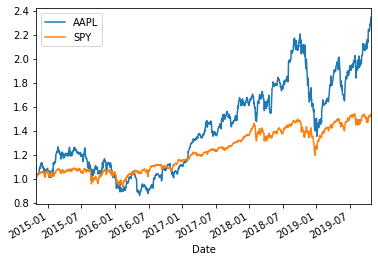

In [29]:
aapl['Cumulative'] = aapl['Close'] / aapl['Close'].iloc[0]
spy_etf['Cumulative'] = spy_etf['Close'] / spy_etf['Close'].iloc[0]
aapl['Cumulative'].plot(label='AAPL')
spy_etf['Cumulative'].plot(label='SPY')
plt.legend();

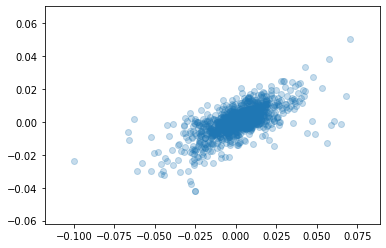

In [31]:
aapl['Daily Return'] = aapl['Close'].pct_change(1)
spy_etf['Daily Return'] = spy_etf['Close'].pct_change(1)
plt.scatter(aapl['Daily Return'], spy_etf['Daily Return'], alpha=0.25);

In [32]:
beta, alpha, r_value, p_value, std_err = stats.linregress(
    aapl['Daily Return'].iloc[1:],
    spy_etf['Daily Return'].iloc[1:]
)
print('beta: {}, alpha: {}, r: {}'.format(beta, alpha, r_value))

beta: 0.36841041536447366, alpha: 8.355896584003129e-05, r: 0.674439909503965
